# Initial Processing

Import Data

null values represented by ? in data

In [ ]:
# load training data

import numpy as np
import pandas as pd

def load_data(file, columns):
  data = pd.read_csv(file, header = None, na_values = ' ?') #replace ? with null
  data = pd.DataFrame(data)
  data.columns = columns

  # drop rows with null values
  data = data.dropna()
  # split into inputs and outputs
  X = data.iloc[:, 0:14]
  Y = data.iloc[:,14]
  #print(X.describe())
  #print(X.info())
  # select categorical and numerical features for column transformer
  cat_ix = X.select_dtypes(include=['object', 'bool']).columns
  num_ix = X.select_dtypes(include=['int64', 'float64']).columns
  return X, Y, cat_ix, num_ix
 
import_file = '/content/adult.data'
cols = ['age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','income']

X, Y, cat_features, num_features = load_data(import_file, cols)



In [ ]:
# load test data
def load_test(file, columns):
  data = pd.read_csv(file, skiprows = [0], na_values = ' ?')
  data = pd.DataFrame(data)
  data.columns = columns
  # drop rows with null values
  data = data.dropna()
  # split into inputs and outputs
  X = data.iloc[:, 0:14]
  Y = data.iloc[:,14]
  #strip out bullet points so that label encoder works
  Y = Y.str.replace(".","", regex=False)
  return X, Y

test_file = '/content/adult.test'
X_test, Y_test = load_test(test_file, cols)

Encode categorical data and scale numerical data


In [ ]:
#column transformer for encoding and scaling X
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy import sparse


def prepare_X(x_train, x_test, cat_features, num_features):
  ct = ColumnTransformer([('c',OneHotEncoder(handle_unknown='ignore'),cat_features),
                          ('n',MinMaxScaler(feature_range=(0, 1)),num_features)])
  ct.fit(x_train)
  train_encoded = ct.transform(x_train)
  train_encoded = sparse.csr_matrix.toarray(train_encoded)
  train_encoded = pd.DataFrame(train_encoded)
  test_encoded = ct.transform(x_test)
  test_encoded = sparse.csr_matrix.toarray(test_encoded)
  test_encoded = pd.DataFrame(test_encoded)
  return train_encoded, test_encoded

X_encoded, X_test_encoded = prepare_X(X, X_test, cat_features, num_features)

In [ ]:
# binarize target label
from sklearn.preprocessing import LabelEncoder

def prepare_Y(y_train, y_test):
  le = LabelEncoder()
  le.fit(y_train.values.ravel())
  y_train_encoded = le.transform(y_train.values.ravel()) 
  y_test_encoded = le.transform(y_test.values.ravel())
  return y_train_encoded, y_test_encoded

Y_encoded, Y_test_encoded = prepare_Y(Y, Y_test)


# Charts

In [ ]:
# Reference: https://machinelearningmastery.com/imbalanced-classification-with-the-adult-income-dataset/
from collections import Counter
from matplotlib import pyplot as plt

# summarize the class distribution
counter = Counter(Y)
for k,v in counter.items():
	per = v / len(Y) * 100
	print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))
 
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))

Y.value_counts().plot(ax=ax[0], kind='bar')
ax[0].set_xlabel("Y train")

Y_test.value_counts().plot(ax=ax[1], kind='bar')
ax[1].set_xlabel("Y test")

plt.show()

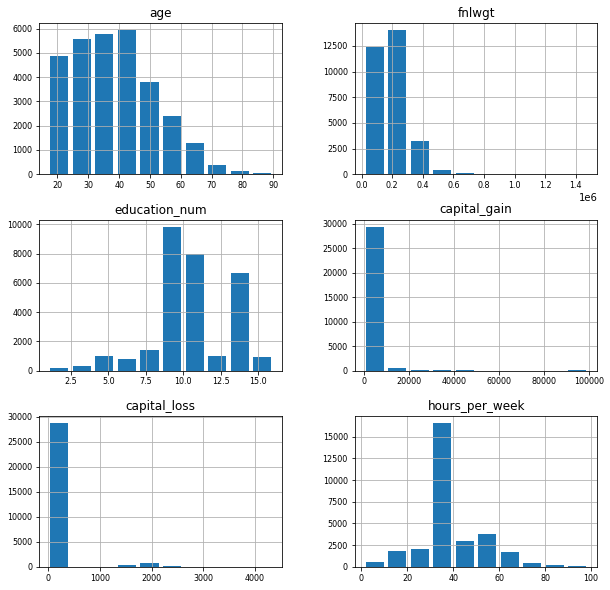

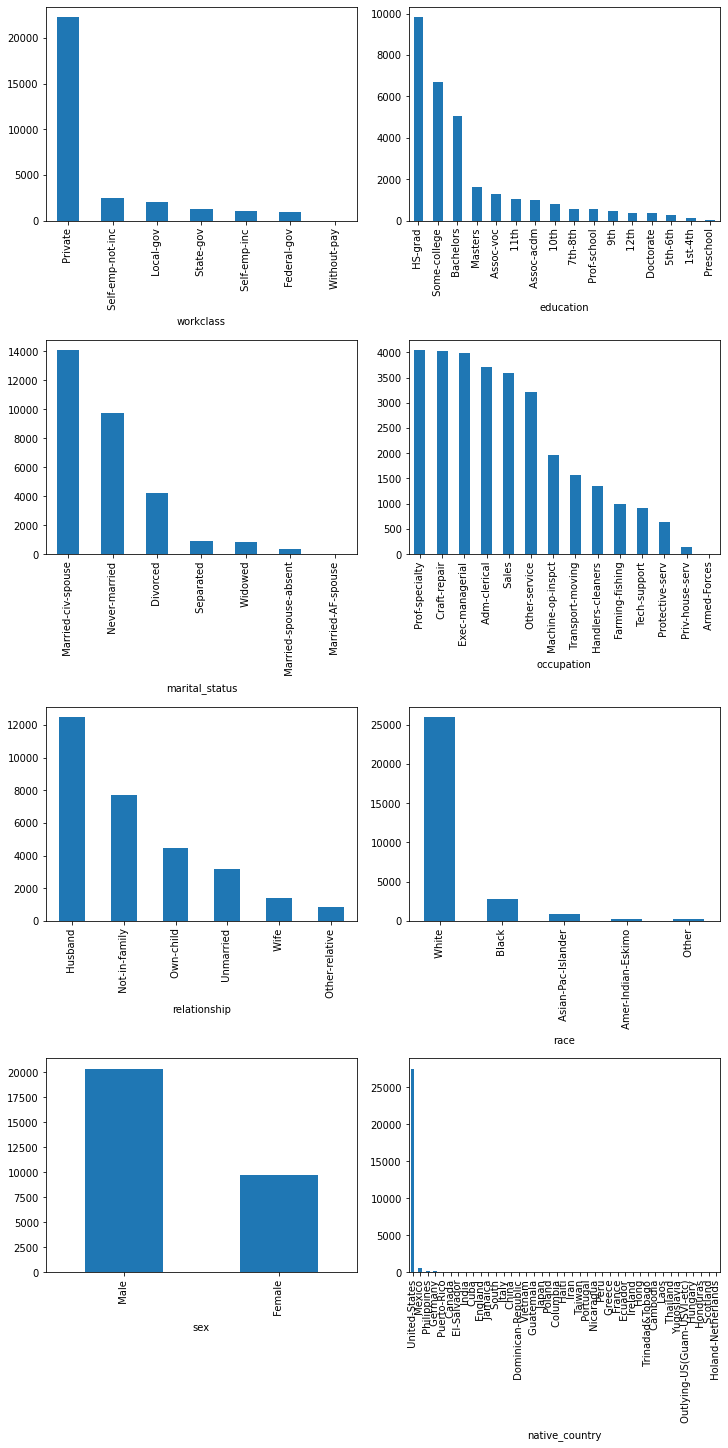

In [ ]:
# Reference: https://machinelearningmastery.com/imbalanced-classification-with-the-adult-income-dataset/

from matplotlib import pyplot as plt

# select columns with numerical data types
subset = X[num_features]
# create a histogram plot for each numeric variable
subset.hist(figsize=(10, 10), xlabelsize=8, ylabelsize=8, rwidth=0.8)

fig, ax = plt.subplots(ncols=2, nrows=4, constrained_layout=True, figsize=(10, 20))
# categorical features
list_num = 0
for i in range(0,4):
  for j in range(0,2):
    variable = cat_features[list_num]
    X[variable].value_counts().plot(ax=ax[i,j], kind='bar')
    ax[i,j].set_xlabel(variable)
    list_num += 1

plt.show()

# Neural Network Classifier

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
import tensorflow as tf

# fix random seed for reproducibility
np.random.seed(7)
tf.random.set_seed(7)

#create model
def create_model(hidden_size1=75,optimizer="Adam",init='he_uniform',activation='relu',dropout=0.0):
  model = Sequential()
  model.add(Dense(100,input_dim=104,kernel_initializer=init,activation=activation))
  model.add(Dropout(dropout)) 
  model.add(Dense(hidden_size1,kernel_initializer=init,activation=activation))
  model.add(Dropout(dropout))
  # model.add(Dense(hidden_size2,kernel_initializer=init,activation=activation))
  # model.add(Dropout(dropout))
  model.add(Dense(1,kernel_initializer=init,activation='sigmoid'))
  #compile model
  model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model,verbose=0)

# Code for ColumnTransformer in pipeline
# steps = list()
# steps.append(('c',OneHotEncoder(handle_unknown='ignore'),cat_features))
# steps.append(('n',MinMaxScaler(feature_range=(0, 1)),num_features))
# ct = ColumnTransformer(transformers=steps)
# pipeline = Pipeline(steps=[('transform',ct),('classifier',model)])
   
param_grid = {
    #'classifier__init': ['glorot_uniform','normal','uniform','he_uniform'],
    #'classifier__activation': ['relu','tanh'],
    #'hidden_size1':[75, 50, 25]
    #'classifier__hidden_size2':[50, 35, 20],
    'classifier__dropout': [0, 0.2],
    #'classifier__optimizer':['RMSprop', 'Adam']
    'epochs': [10]
    #'batch_size':[5, 10, 20]
}

random_state = 7
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=kfold, n_jobs=-1)

grid_result = grid.fit(X_encoded,Y_encoded)

#summarize results
print("Best: %f using %s" % (grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means,stds,params):
  print("%f (%f) with: %r" % (mean,stdev,param))

Best: 0.848651 using {'batch_size': 5, 'epochs': 10}
0.848651 (0.004691) with: {'batch_size': 5, 'epochs': 10}
0.847888 (0.003900) with: {'batch_size': 10, 'epochs': 10}
0.846562 (0.005639) with: {'batch_size': 20, 'epochs': 10}


# Plots of training neural network

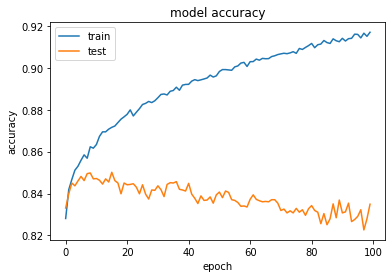

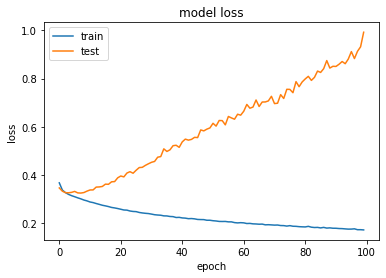

In [ ]:
plt.plot(best_history.history['accuracy'])
plt.plot(best_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

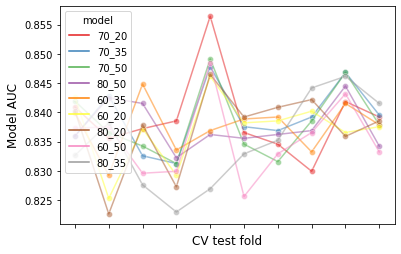

Correlation of models:
 model     70_20     70_35     70_50  ...     80_20     60_50     80_35
model                                ...                              
70_20  1.000000  0.530763  0.716593  ...  0.340015  0.666949 -0.377637
70_35  0.530763  1.000000  0.815872  ...  0.199769  0.829304  0.484166
70_50  0.716593  0.815872  1.000000  ...  0.417524  0.887419  0.270811
80_50 -0.048762  0.444132  0.323137  ... -0.239475  0.333297  0.435857
60_35  0.177460 -0.161698  0.125327  ...  0.516927 -0.125539 -0.090591
60_20  0.459069  0.233974  0.533287  ...  0.976101  0.353509 -0.016997
80_20  0.340015  0.199769  0.417524  ...  1.000000  0.255829  0.044577
60_50  0.666949  0.829304  0.887419  ...  0.255829  1.000000  0.232498
80_35 -0.377637  0.484166  0.270811  ...  0.044577  0.232498  1.000000

[9 rows x 9 columns]


In [ ]:
#performance of models on each fold. 
#Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html

import seaborn as sns
# create df of model scores ordered by perfomance
model_scores = results_df.filter(regex=r'split\d*_test_score')

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False, palette='Set1', marker='o', alpha=.5, ax=ax
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

# print correlation of AUC scores across folds
#print(f"Correlation of models:\n {model_scores.transpose().corr()}")

# Testing

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Best estimator from gridsearchcv
best_model = grid_result.best_estimator_

test_results = (best_model.predict(X_test_encoded)> 0.5).astype("int32")

report = classification_report(Y_test_encoded, test_results)
matrix = confusion_matrix(Y_test_encoded, test_results)

print(report)
print(matrix)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.88      0.93      0.90     11359
           1       0.73      0.60      0.66      3700

    accuracy                           0.85     15059
   macro avg       0.80      0.76      0.78     15059
weighted avg       0.84      0.85      0.84     15059

[[10542   817]
 [ 1480  2220]]


# WAME Optimizer

Tried to write optimizer in keras tensorflow using the following references:
https://cloudxlab.com/blog/writing-custom-optimizer-in-tensorflow-and-keras/
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer#creating_a_custom_optimizer_2

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Optimizer
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.framework import ops
import numpy as np
import os

class WAME(Optimizer):
  # constructor
  def __init__(self, alpha = 0.9, e_plus = 1.2, e_minus = 0.1, z_min = 0.01, z_max = 100, learning_rate = 0.01, name="WAME", **kwargs):
    """Call super().__init__() and use _set_hyper() to store hyperparameters"""
    super().__init__(name, **kwargs)
    self._set_hyper("alpha", kwargs.get("alpha", alpha))
    self._set_hyper("learning_rate", kwargs.get("lr", learning_rate))
    self._set_hyper("e_plus", kwargs.get("e_plus", e_plus))
    self._set_hyper("e_minus", kwargs.get("e_minus", e_minus))
    self._set_hyper("z_min", kwargs.get("z_min", z_min))
    self._set_hyper("z_max", kwargs.get("z_max", z_max))
    self._is_first = True #??

  # create slots (variables)
  def _create_slots(self, var_list):
    """For each model variable, create the optimizer variable associated with it.
    TensorFlow calls these optimizer variables "slots".
    """
    for var in var_list:
        self.add_slot(var, "prvz") #previous variable Z
    for var in var_list:
        self.add_slot(var, "prvzeta") #previous zeta
    for var in var_list:
        self.add_slot(var, "prvtheta") #previous variable theta
    for var in var_list:
        self.add_slot(var, "prvw") #previous weights
    for var in var_list:
        self.add_slot(var, "prvgrad") #previous gradient

  #method called per layer. provides gradient and variables.
  @tf.function
  def _resource_apply_dense(self, grad, var):
    """Update the slots and perform one optimization step for one model variable
    """
    # Extract the previous values of Variables and Gradients
    prvz = self.get_slot(var, "prvz")
    prvzeta = self.get_slot(var, "prvzeta")
    prvtheta = self.get_slot(var, "prvtheta")
    prvw = self.get_slot(var, "prvw")
    prvgrad = self.get_slot(var, "prvgrad")

    # Get the hyperparameters - not sure if this is necessary
    alpha = self._get_hyper("alpha")
    lr = self._get_hyper("learning_rate")
    e_plus = self._get_hyper("e_plus")
    e_minus = self._get_hyper("e_minus")
    z_min = self._get_hyper("z_min")
    z_max = self._get_hyper("z_max")
    
    # If it first time, use base case for variables.
    if self._is_first:
      self._is_first = False
      zeta = 1
      z = (1-alpha)
      theta = (1-alpha)*pow(grad,2)
      weight_change = -lr/z * grad * 1/theta
      new_var = var + weight_change

    else:
      # if gradient same sign as previous
      if grad * prvgrad > 0:
        zeta = min(prvzeta*e_plus, z_max)
      # if gradient has switched sign
      elif grad * prvgrad < 0:
        zeta = max(prvzeta*e_minus, z_min)

      z = (alpha * prvz) + (1-alpha) * zeta
      theta = (alpha * prvtheta) + (1-alpha)*pow(grad,2)
      weight_change = -lr/z * grad/theta
      new_var = prvw + weight_change
            
    # Save the current values in the slots.
    prvz.assign(z)
    prvzeta.assign(zeta)
    prvtheta.assign(theta)
    prvw.assign(var)
    prvgrad.assign(grad)

    # Update weights
    var.assign(new_var)

  def _resource_apply_sparse(self, grad, var):
    raise NotImplementedError
  # serialization of the optimizer, include all hyper parameters
  def get_config(self):
    base_config = super().get_config()
    return {
      **base_config,
      "alpha": self._serialize_hyperparameter("alpha"),
      "learning_rate": self._serialize_hyperparameter("learning_rate"),
      "e_plus": self._serialize_hyperparameter("e_plus"),
      "e_minus": self._serialize_hyperparameter("e_minus"),
      "z_min": self._serialize_hyperparameter("z_min"),
      "z_max": self._serialize_hyperparameter("z_max"),  
    } 

In [ ]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def best_model(hidden_size=15, optimizer=WAME(),init='he_uniform',dropout=0.0):
  model = Sequential()
  model.add(Dense(50,input_dim=104,kernel_initializer=init,activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(hidden_size,kernel_initializer=init,activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(1,kernel_initializer=init,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])  
  return model

bestmodel = KerasClassifier(build_fn=best_model,verbose=0)
best_history = bestmodel.fit(X_encoded, Y_encoded, epochs=10, batch_size=5, validation_split = 0.2, verbose=0)

test_results = (bestmodel.predict(X_test_encoded)> 0.5).astype("int32")

report = classification_report(Y_test_encoded, test_results)
matrix = confusion_matrix(Y_test_encoded, test_results)

print(report)
print(matrix)

ValueError: ignored